Apply TF-IDF to the Inaugural Corpus 
Our second assignment will have us write code to 
1. Define or augment a set of stopwords for this problem
2. Construct a document-by-term matrix (documents will be rows, terms will be columns), along with a vocabulary while controlling for stopwords
3. Write functions to comput TF-IDF and apply those to the document-by-term matrix
4. Find the closest historic inaugural address to the 2017 address by President Trump
5. Learn to use the PCA transformation and plot the inaugural address along the first two principal components

In [1]:
# import library
import re
import math
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.corpus import inaugural
from nltk import FreqDist

In [2]:
# initialize stemmer and lemmatizer
porter    = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()
wnl       = nltk.WordNetLemmatizer()

In [3]:
# display the first 4 items of the inaugural datasets
inaugural.fileids()[:4]

['1789-Washington.txt',
 '1793-Washington.txt',
 '1797-Adams.txt',
 '1801-Jefferson.txt']

In [4]:
# display the tokenized words from the first inaugural 
inaugural.words(inaugural.fileids()[0])

['Fellow', '-', 'Citizens', 'of', 'the', 'Senate', ...]

In [5]:
# initial stop words
stop_words = set(stopwords.words('english'))

### 1. Stopwords

**Update stopwords**

Remove all punctuation and strange unicode characters, and anything else that might be extraneous

In [6]:
# here is where you should update the stop words
stop_words.update(['-', ',', '.', '!', '?', ' ', ':', ';', '/', '[', ']', 
                   '*', '"', '(', ')', '#', '$', '%', '&', '~', '@', '<', '>',
                  '{', '}', '^', '--', "'", '."', '14th', '";', '"?', '),', '...', 
                   '¡¦', '¡§', '¡¨¡', ',"', '.)', '....', '\x80\x94', '¡', '.¡¨'])

---
### 2. Read each inaugural address into an Pandas DataFrame

**2.1 Create a vocabulary as a set of all unique stemmed terms in the corpus**

In [7]:
# define an empty set to store vocabs
vocab = set()

In [8]:
# your code for creating the vocab goes here
temp_list = [wnl.lemmatize(porter.stem(w.lower())) for w in inaugural.words() if w.lower() not in stop_words]
vocab = set(sorted(temp_list))

In [9]:
len(vocab)

5399

**2.2 Use your vocabulary now to read each inaugural address into a dataframe**

Each row of the dataframe should represent a document (one of the addresses). It may be handy at this time to also track the size (length) of each document, since you'll need this later when computing TF.

You should ignore the README file. Hint: use `inaugural.fileids()`.

In [10]:
# Feel free to use your own approach but you can iteratively update a dataframe using dictionaries.
# Here's an example
df =pd.DataFrame()

dict1 = {'a':2, 'b':3, 'c':4}
dict2 = {'b':30, 'a':20, 'd':50, 'c':40}

df = df.append(dict1, ignore_index=True)
df = df.append(dict2, ignore_index=True)

print(df)

      a     b     c     d
0   2.0   3.0   4.0   NaN
1  20.0  30.0  40.0  50.0


In [11]:
# your code for creating the dataframe goes here.
# the resulting dataframe should be called "df"
#
# Each row of the dataframe should represent a document (inaugural address)
# Each column of the dataframe should be a term from the vocab

# initiate a dictionary for tracking document size
doc_length = {}
# initiate an empty dataframe
df = pd.DataFrame()
# loop through all documents in corpus
for fileid in inaugural.fileids():
    # populate doc_length
    doc_length[fileid] = len(inaugural.words(fileid))
    # create a temporary dictionary for each document for tracking word frequency
    temp_list = [wnl.lemmatize(porter.stem(w.lower())) for w in inaugural.words(fileid) 
                 if w.lower() not in stop_words]
    temp_dict = dict(FreqDist(sorted(temp_list)))
    # covert dictionary to series and add to dataframe
    df = df.append(pd.Series(temp_dict, name = fileid))
    pass
# fill null value
df.fillna(0, inplace = True)
# check df size
print(df.shape)

(58, 5399)


---
### 3. Compute TF-IDF for the document-term matrix ###

**3.1. Write a function to compute term frequency (TF) for each document**

Please write your own code here, and resist the urge to rely on google for your answer.

In [12]:
# compute term frequency
# inputs: wordvec is a series that contains, for a given doc, 
#                 the word counts for each term in the vocab
#         doclen  is the length of the document
# returns: a series with new term-frequencies (raw counts divided by doc length)
def computetf(wordvec,doclen):
    return wordvec/doclen

**3.2 Write a function to comput inverse document frequency**

Please write your own code here and resiste the urge to rely on google for your answer.

In [13]:
import math # you may need this for the log function

# input:   document-by-term (row-by-column) dataframe
# returns: dictionary of key-value pairs. Keys are terms in the vocab, values are IDF.

def computeidf(df):
    idf_dict = {}
    for vocab in df.columns.values:
        ratio = df.shape[0] / (df[vocab] > 0).sum()
        idf_dict[vocab] = math.log(ratio)
        pass
    return idf_dict

**Create a new dataframe and populate it with the TF-IDF values for each document-term combination**

The functions your write above should work with the below code snippet.

In [14]:
newdf = pd.DataFrame()

idfdict = computeidf(df)

cols = df.columns
for index, row in df.iterrows():
    newrow = computetf(row,doc_length[index])
    for c in cols:
        newrow[c] = newrow[c]*idfdict[c]
    newdf = newdf.append(newrow)

---
### 4. Using TF-IDF values, find and rank order the 3 closest inaugural addresses to Donald Trump's 2017 address, measured by cosine similarity

In [15]:
# President Trump's address is 57 (0-indexed)
# newdf.iloc[57,:].head(100)

**4.1 Create an array called dist that contains the cosine similarity distance between the 2017 inaugural address (called d1 below) and each of the inaugural addresses**

In [16]:
import numpy as np

d1 = newdf.iloc[57,:]
norm_d1 = np.sqrt(np.sum(np.square(d1)))
dist = []
for index,row in newdf.iterrows():
    # your code goes here
    temp_norm = np.sqrt(np.sum(np.square(row)))
    cos_sim = np.dot(d1, row) / (norm_d1 * temp_norm)
    dist.append(cos_sim)


In [17]:
dist

[0.028385851015777314,
 0.0345546064891253,
 0.05480366567025921,
 0.04803021286999383,
 0.05247969976729038,
 0.029944498561771633,
 0.03208027620229345,
 0.05883140162065671,
 0.051603876423959416,
 0.051848871390321766,
 0.03200839137736795,
 0.03865103824903881,
 0.059814011716078905,
 0.07610944439922337,
 0.07155426534451145,
 0.055727702129309845,
 0.06485577717401546,
 0.06498183584967497,
 0.0459755398274426,
 0.035769805894818686,
 0.05626692859038358,
 0.04366333426642948,
 0.044050102215994695,
 0.07009131900137894,
 0.06272011941900518,
 0.07083657708889558,
 0.051139690256612046,
 0.0668931143944216,
 0.05552005660876715,
 0.056809887269136175,
 0.06463770145510213,
 0.08733100768489739,
 0.06495303021799227,
 0.09778841897254424,
 0.09252905342560866,
 0.08554751202461289,
 0.07182304933131382,
 0.09937564191160811,
 0.09097355455798457,
 0.07437084790237614,
 0.06486141198864709,
 0.10684892613545827,
 0.11319633990771226,
 0.10830843814191936,
 0.08458868813467971,
 0.

**4.2 Find the 3 closest associated inaugural address, when measured by cosign similarity. Which one is the closest?**

In [18]:
indices = np.array(dist).argsort()[-4:-1]
df.index[indices]

Index(['1969-Nixon.txt', '1997-Clinton.txt', '1993-Clinton.txt'], dtype='object')

**4.3 What is your explanation/understanding of why these documents are "close" to the 2017? Please explain.

Cosine similarity is often used in text classification to measure the textual content similarity of two documents. This is normally calculated based on word frequencies relative to the entire corpus, which can be meaninfully represented using TF-IDF.

In this case, inaugural A is considered 'close' to inaugural B if the words used and frequencies of each word used are relatively similar than the ones between inaugural A and inaugural B. As illustrated in the code snippets below, the first dataframe dipicts the words that appeared more than 5 times in Trump's inaugural and also appeared at least once in the 3 closest associated inaugural address. We could see that these words such as 'america', 'great', 'people', 'nation' were also frequently used by the other 3 presidents.

In contrast, the second dataframe shows the 3 furtherest asocaited inaugural address, where such pattern is pattern is not observed. 

In [19]:
similar_df = df.loc[['1969-Nixon.txt', '1997-Clinton.txt', '1993-Clinton.txt', '2017-Trump.txt'], :]
keywords = [w for w in similar_df.columns if (similar_df[w]>0).sum() >= 4 and similar_df.loc['2017-Trump.txt', w] >= 5]
similar_df[keywords]

,american,great,nation,new,one,peopl,presid,world,america,make,god,across,today
1969-Nixon.txt,4.0,7.0,9.0,8.0,7.0,15.0,3.0,15.0,6.0,10.0,6.0,1.0,5.0
1997-Clinton.txt,16.0,6.0,15.0,29.0,10.0,11.0,1.0,15.0,15.0,5.0,1.0,2.0,6.0
1993-Clinton.txt,14.0,2.0,5.0,9.0,1.0,12.0,3.0,20.0,19.0,3.0,2.0,4.0,10.0
2017-Trump.txt,15.0,6.0,13.0,6.0,9.0,10.0,5.0,6.0,20.0,6.0,5.0,5.0,5.0


In [20]:
df.index[np.array(dist).argsort()[:3]]

Index(['1789-Washington.txt', '1809-Madison.txt', '1829-Jackson.txt'], dtype='object')

In [21]:
diff_df = df.loc[['1789-Washington.txt', '1809-Madison.txt', '1829-Jackson.txt', '2017-Trump.txt'], :]
keywords = [w for w in diff_df.columns if (diff_df[w]>0).sum() >= 4 and diff_df.loc['2017-Trump.txt', w] >= 5]
diff_df[keywords]

,countri,everi,nation,never,peopl,right
1789-Washington.txt,5.0,9.0,4.0,2.0,4.0,2.0
1809-Madison.txt,5.0,2.0,10.0,1.0,1.0,5.0
1829-Jackson.txt,2.0,1.0,6.0,1.0,4.0,4.0
2017-Trump.txt,12.0,7.0,13.0,6.0,10.0,5.0


---
### 5. Compute the first two principal components of the TF-IDF matrix, and plot each document along each of the PCA components
For this question, feel free to use google, stackoverflow, etc to help you compute the PCA (it's pretty easy, just one or two lines). Don't worry too much about the theory for now - we're going to discuss the Principal Component Decomposition later in the semester.

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [23]:
# your code to compute the PCA goes here
# The result should be X, an array of 2-element arrays
pca = PCA(n_components=2)
X = pca.fit_transform(newdf)

In [24]:
len(X)

58

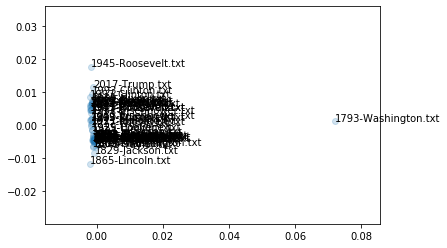

In [25]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.axis('equal');
for i in range(0,58):
    plt.text(X[i,0],X[i,1],inaugural.fileids()[i])